# **Homework 1: Linear Regression**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->


若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# **Load 'train.csv'**
HW1_train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [ ]:
import sys
import pandas as pd
import numpy as np

data = pd.read_csv('./dataset/ex1_train.csv', encoding = 'big5')

data[:50]

# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [29]:
data = data.iloc[:, 3:]
print(data.shape)
data[data == 'NR'] = 0
raw_data = data.to_numpy()
raw_data.shape

(4320, 21)


(4320, 21)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,14,14,14,13,12,12,12,12,15,17,...,22,22,21,19,17,16,15,15,15,15
1,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,0.51,0.41,0.39,0.37,0.35,0.3,0.37,0.47,0.78,0.74,...,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,0.2,0.15,0.13,0.12,0.11,0.06,0.1,0.13,0.26,0.23,...,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,0.9,0.6,0.5,1.7,1.8,1.5,1.9,2.2,6.6,7.9,...,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5


# **Extract Features (1)**

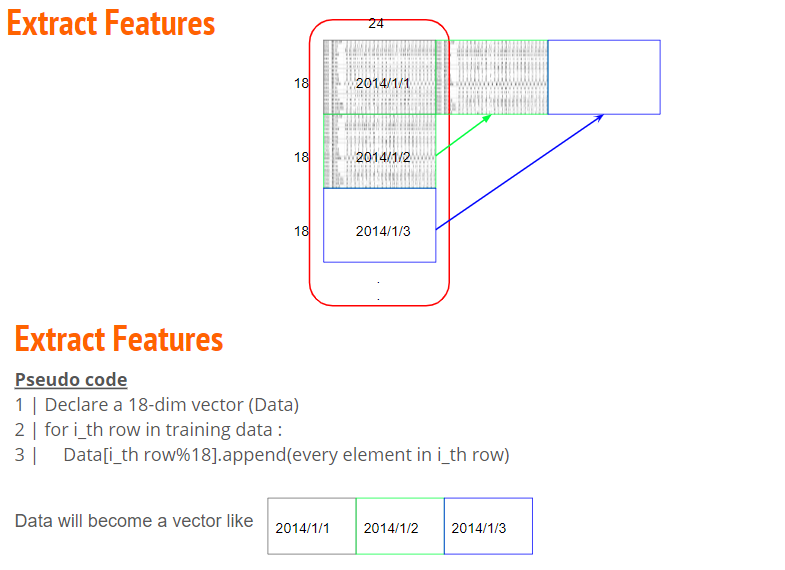

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [5]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
month_data

{0: array([[14.  , 14.  , 14.  , ..., 14.  , 13.  , 13.  ],
        [ 1.8 ,  1.8 ,  1.8 , ...,  1.8 ,  1.8 ,  1.8 ],
        [ 0.51,  0.41,  0.39, ...,  0.34,  0.41,  0.43],
        ...,
        [35.  , 79.  ,  2.4 , ..., 48.  , 63.  , 53.  ],
        [ 1.4 ,  1.8 ,  1.  , ...,  1.1 ,  1.9 ,  1.9 ],
        [ 0.5 ,  0.9 ,  0.6 , ...,  1.2 ,  1.2 ,  1.3 ]]),
 1: array([[ 15.  ,  14.  ,  14.  , ...,   8.4 ,   8.  ,   7.6 ],
        [  1.8 ,   1.8 ,   1.7 , ...,   1.7 ,   1.7 ,   1.7 ],
        [  0.27,   0.26,   0.25, ...,   0.36,   0.35,   0.32],
        ...,
        [113.  , 109.  , 104.  , ...,  72.  ,  65.  ,  69.  ],
        [  2.3 ,   2.2 ,   2.6 , ...,   1.9 ,   2.9 ,   1.5 ],
        [  2.5 ,   2.2 ,   2.2 , ...,   0.9 ,   1.6 ,   1.1 ]]),
 2: array([[ 18.  ,  18.  ,  18.  , ...,  14.  ,  13.  ,  13.  ],
        [  1.8 ,   1.8 ,   1.8 , ...,   1.8 ,   1.8 ,   1.8 ],
        [  0.39,   0.36,   0.4 , ...,   0.42,   0.47,   0.49],
        ...,
        [103.  , 128.  , 115.  , ...,  

# **Extract Features (2)**

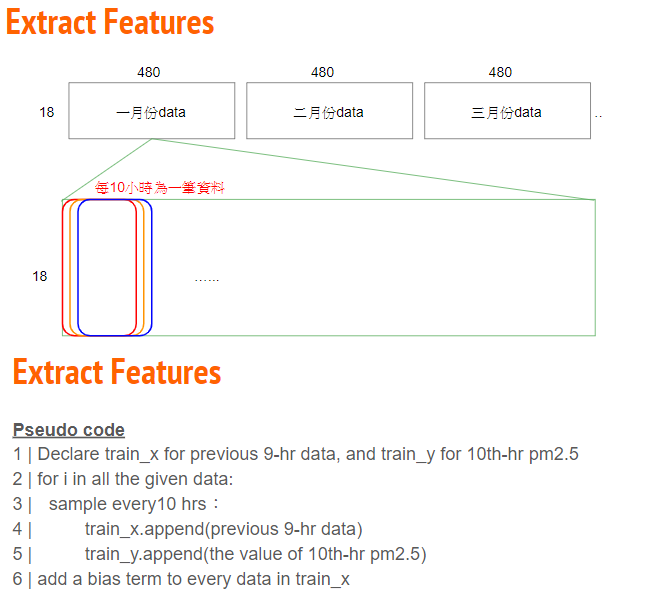

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [118]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
print(x)
print(y)

[[14.  14.  14.  ...  2.   2.   0.5]
 [14.  14.  13.  ...  2.   0.5  0.3]
 [14.  13.  12.  ...  0.5  0.3  0.8]
 ...
 [17.  18.  19.  ...  1.1  1.4  1.3]
 [18.  19.  18.  ...  1.4  1.3  1.6]
 [19.  18.  17.  ...  1.3  1.6  1.8]]
[[30.]
 [41.]
 [44.]
 ...
 [17.]
 [24.]
 [29.]]


# **Normalize (1)**


In [119]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

# **Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [120]:
#生成一维数组l，生成0-5651
def test1():
    l = []
    for i in range(5652):
        l.append(i)
        np.random.shuffle(l) #打乱数组
    return l

In [121]:
#划分训练集和验证集
#print(test1())
l1 = test1()
x_new = []
y_new = []
for i in l1:
    x_new.append(x[i])
    y_new.append(y[i])
x_new = np.array(x_new)
y_new = np.array(y_new)
#print("第一个是：",x_new[0])
#print("第二个是：",y_new[0])


In [122]:
import math
x_train = x_new[: math.floor(len(x_new) * 0.8), :]
y_train = y_new[: math.floor(len(y_new) * 0.8), :]
x_validation = x_new[math.floor(len(x_new) * 0.8): , :]
y_validation = y_new[math.floor(len(y_new) * 0.8): , :]
print(x_train)
print(y_train)
print(x_validation)
print(y_validation)
print(len(x_train))
print(len(y_train))
print(len(x_validation))
print(len(y_validation))
print(np.shape(x_train))
print(np.shape(y_train))

[[ 0.86929969  0.70886668  0.70748265 ... -0.29578943 -0.57750692
  -0.48454426]
 [ 0.86929969  1.0269753   0.86645993 ... -0.38950555  0.1719923
   0.07797893]
 [ 0.23285597  0.23170375  0.23055081 ...  0.82880401 -1.13963133
  -1.14082131]
 ...
 [ 0.55107783  0.70886668  1.02543721 ...  1.01623625  0.45305451
  -0.95331358]
 [-0.88092053 -1.04073074 -1.04126744 ... -0.38950555 -0.20275731
   0.26548666]
 [-0.08536588 -0.24545919 -0.24638103 ...  0.26650729  1.20255373
   0.1717328 ]]
[[10.]
 [ 0.]
 [51.]
 ...
 [12.]
 [ 5.]
 [ 8.]]
[[ 0.23285597  0.39075806  0.54850537 ...  1.67224908  1.29624113
   0.82800985]
 [ 0.55107783  0.54981237  0.54850537 ...  0.26650729  0.45305451
   1.10927144]
 [-0.08536588 -0.08640488 -0.24638103 ... -1.23295063  0.0783049
  -0.85955971]
 ...
 [ 0.86929969  0.54981237  0.23055081 ...  0.45393953  1.10886632
   0.64050212]
 [ 0.55107783  0.54981237  0.54850537 ... -0.95180227 -0.67119432
  -0.39079039]
 [-0.56269867 -0.56356781 -0.56433559 ... -0.7643700

In [ ]:
def train(x_train, y_train, epoch):
    bias = 0 #初始化偏置值
    weights = np.ones(9) #初始化权重值
    learning_rate = 1 #学习率
    reg_rate = 0.1 #正则项系数
    b_g2 = 0
    w_g2 = np.zeros(9)
    #w_new = np.zeros(9) #更新后的权重
    #b_new = 0 #更新后的偏置值
    
    for i in range(1600):
        b_g = 0
        w_g = np.zeros(9)
        #计算loss_lb的梯度
        for j in range(4521):
            b_g +=  (y_train[j] - weights.dot(x_train[j,  :9]) - bias) * (-1)
            for k in range(9):
                w_g[k] +=  (y_train[j] - weights.dot(x_train[j,  :9]) - bias) * (-x_train[j, k])
        #除以总数num
        b_g /= 4521
        w_g /= 4521
        
        b_g *= 2
        w_g *=2
        #加上正则项的梯度
        for m in range(9):
            w_g[m] += 2* reg_rate * weights[m]
        b_g2 += b_g**2
        w_g2 += w_g**2
        #梯度更新
        bias -= learning_rate/b_g2**0.5 * b_g
        weights -= learning_rate/w_g2**0.5 * w_g
        
        if (i%250 == 0):
            loss = 0
            for j in range(4521):
                loss += (y_train[j] - weights.dot(x_train[j, :9]) - bias)**2
            print("经过%i次迭代，损失值是%f"%(i,loss))
    return weights, bias

In [ ]:
epoch = 1000
x_train = x_new[: math.floor(len(x_new) * 0.8), :]
y_train = y_new[: math.floor(len(y_new) * 0.8), :]
#x_validation = x_new[math.floor(len(x_new) * 0.8): , :]
#y_validation = y_new[math.floor(len(y_new) * 0.8): , :]
w, b =train(x_train,y_train,epoch)
#loss = vali(x_validation,y_validation,w,b)
print('the loss on val data is:', loss)




In [ ]:
epoch = 2000
x_train = x_new[: math.floor(len(x_new) * 0.8), :]
y_train = y_new[: math.floor(len(y_new) * 0.8), :]
x_validation = x_new[math.floor(len(x_new) * 0.8): , :]
y_validation = y_new[math.floor(len(y_new) * 0.8): , :]
w, b =train(x_train,y_train,epoch)
loss = vali(x_validation,y_validation,w,b)
print('the loss on val data is:', loss)


In [ ]:
def vali(x_validation,y_validation,weights,bias):
    loss =0
    for i in range(1131):
        loss += (y_validation[i] - weights.dot(x_validation[i,:9] )- bias)**2
    return loss/1131
print(1)

# **Training**


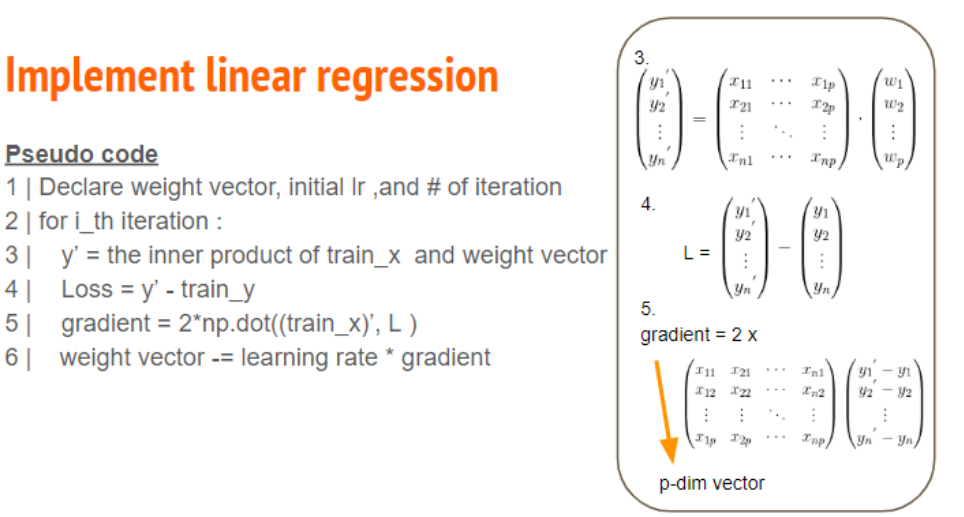


xian
Adagrad 参考 https://www.jianshu.com/p/a8637d1bb3fc

Adam 参考:http://zh.d2l.ai/chapter_optimization/adam.html

https://www.bilibili.com/video/BV134411q793?from=search&seid=2695460006387888571

https://www.bilibili.com/video/BV1i741147Q5?from=search&seid=9039702007790987137




(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [ ]:
dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12) # rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) # dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)
# w

# **Testing**

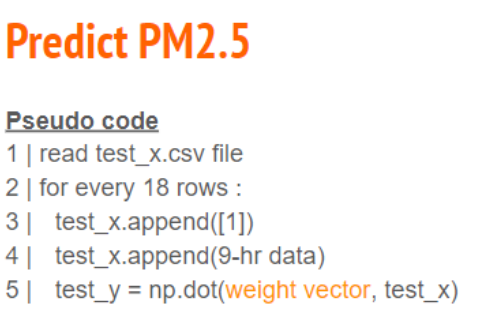

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [10]:
testdata = pd.read_csv('./dataset/ex1_test.csv', encoding = 'big5')
testdata

,id,observation,0,1,2,3,4,5,6,7,8,9
0,id_0,AMB_TEMP,19.30,19.00,18.90,18.90,19.00,19.10,19.10,19.20,19.70,20.80
1,id_0,CH4,2.00,1.97,1.95,1.96,1.89,1.90,1.87,1.86,1.90,1.90
2,id_0,CO,0.73,0.72,0.69,0.63,0.54,0.50,0.53,0.54,0.66,0.73
3,id_0,NMHC,0.22,0.24,0.20,0.20,0.12,0.10,0.11,0.11,0.15,0.19
4,id_0,NO,2.40,2.20,2.00,1.90,1.80,1.40,1.90,3.10,6.20,8.70
...,...,...,...,...,...,...,...,...,...,...,...,...
4315,id_239,THC,1.71,1.68,1.73,1.83,1.83,1.85,1.79,1.73,1.69,1.68
4316,id_239,WD_HR,216.00,213.00,230.00,245.00,220.00,251.00,290.00,241.00,218.00,214.00
4317,id_239,WIND_DIREC,211.00,211.00,235.00,244.00,228.00,265.00,236.00,230.00,205.00,219.00
4318,id_239,WIND_SPEED,2.50,2.40,1.10,1.90,1.50,0.90,1.70,1.90,4.20,4.00


In [11]:
test_data = testdata.iloc[:, 2:11]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

array([[ 1.        , -0.51496539, -0.56356781, ..., -0.67065391,
        -0.48381951, -1.04706744],
       [ 1.        , -0.41949883, -0.48404065, ..., -0.95180227,
        -0.67119432, -1.04706744],
       [ 1.        , -0.68998741, -0.73852755, ..., -0.57693779,
        -0.95225653, -0.67205199],
       ...,
       [ 1.        ,  0.69427767,  0.72477211, ..., -0.76437003,
        -0.95225653, -0.01577493],
       [ 1.        ,  0.75792204,  0.61343409, ..., -1.32666675,
        -0.0153825 ,  0.64050212],
       [ 1.        ,  0.63063329,  0.62933952, ..., -1.13923451,
        -0.48381951,  0.92176371]])

In [12]:
test_x.shape

(240, 163)

# **Prediction**
說明圖同上

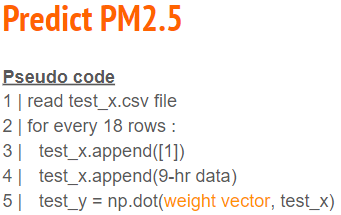

有了 weight 和測試資料即可預測 target。

In [13]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
# ans_y

In [14]:
ans_y.shape

(240, 1)

# **Save Prediction to CSV File**


In [15]:
import csv
with open('submit_2021.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
#         print(row)

['id', 'value']


In [16]:
preds_csv = pd.read_csv('./submit_2021.csv')
preds_csv

,id,value
0,id_0,25.277393
1,id_1,20.877813
2,id_2,14.923732
3,id_3,22.420981
4,id_4,9.348787
...,...,...
235,id_235,14.586679
236,id_236,13.933357
237,id_237,12.507439
238,id_238,12.005351


In [17]:
preds_value = np.array(preds_csv.value)
# len(preds_values), type(preds_values[0]), preds_values

In [18]:
testdata.iloc[:, 2:12]

,0,1,2,3,4,5,6,7,8,9
0,19.30,19.00,18.90,18.90,19.00,19.10,19.10,19.20,19.70,20.80
1,2.00,1.97,1.95,1.96,1.89,1.90,1.87,1.86,1.90,1.90
2,0.73,0.72,0.69,0.63,0.54,0.50,0.53,0.54,0.66,0.73
3,0.22,0.24,0.20,0.20,0.12,0.10,0.11,0.11,0.15,0.19
4,2.40,2.20,2.00,1.90,1.80,1.40,1.90,3.10,6.20,8.70
...,...,...,...,...,...,...,...,...,...,...
4315,1.71,1.68,1.73,1.83,1.83,1.85,1.79,1.73,1.69,1.68
4316,216.00,213.00,230.00,245.00,220.00,251.00,290.00,241.00,218.00,214.00
4317,211.00,211.00,235.00,244.00,228.00,265.00,236.00,230.00,205.00,219.00
4318,2.50,2.40,1.10,1.90,1.50,0.90,1.70,1.90,4.20,4.00


In [19]:
get_private_data = testdata.iloc[:, 2:12]
get_private_data[get_private_data == 'NR'] = 0
get_private_data = np.array(get_private_data)
private_value = []
for i in range(240):
    PM = get_private_data[18*i + 9 :18*i + 10, -1:]
    private_value.append(PM[0][0])
# len(private_value), private_value

## 处理无效数字

private中，第四个为 nan 数据异常，丢弃

In [20]:
private_value = np.array(private_value).reshape(-1, )
private_value = np.delete(private_value, [4])
# private_value, len(private_value)

## RMSE

In [21]:
preds_value = np.delete(preds_value, [4])

In [22]:
# preds_value

In [23]:
error = preds_value - private_value
# (np.sum((error )** 2) /239) ** 0.5

In [24]:
RMSE = np.sqrt(np.mean(error**2))
RMSE

39.98743024702257

以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit

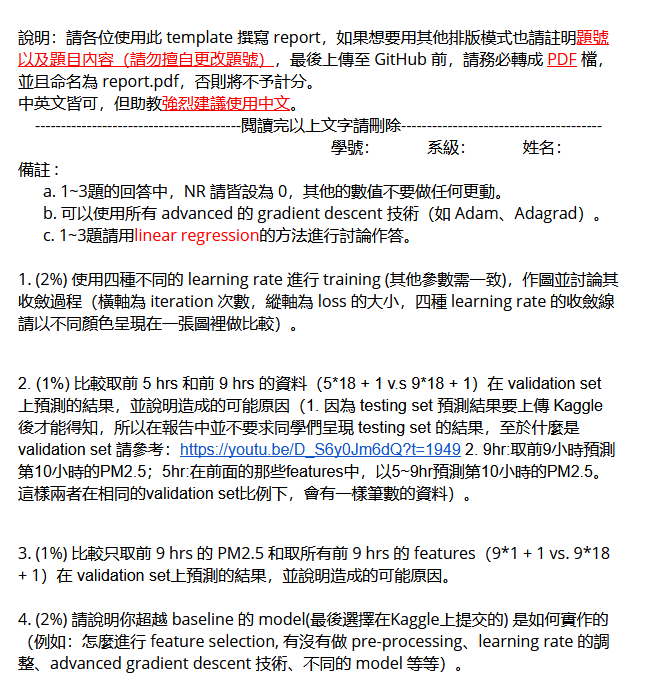

# 梯度下降扩展阅读

### 以下是李宏毅梯度下降课 的笔记

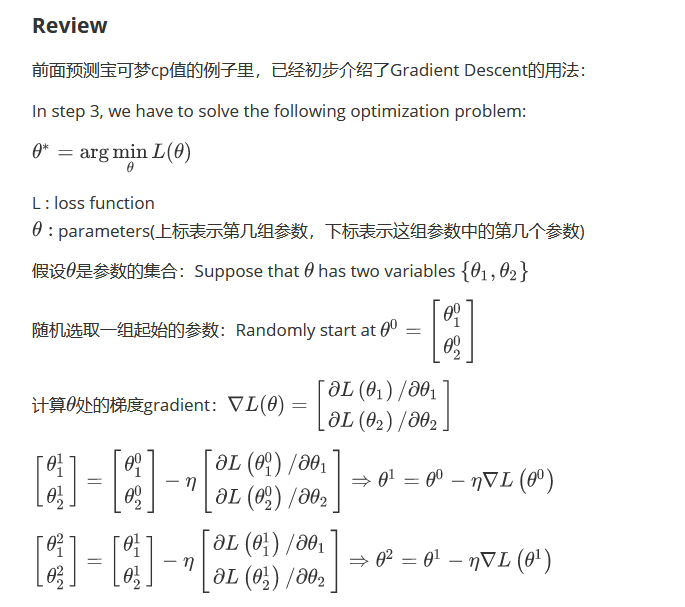

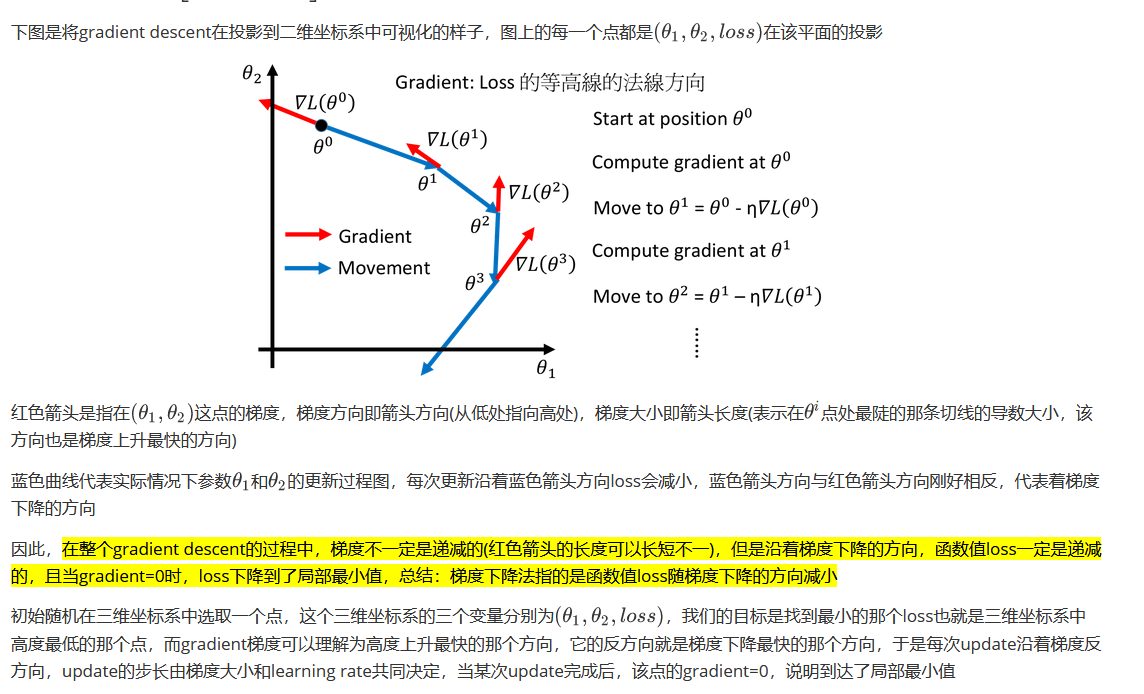

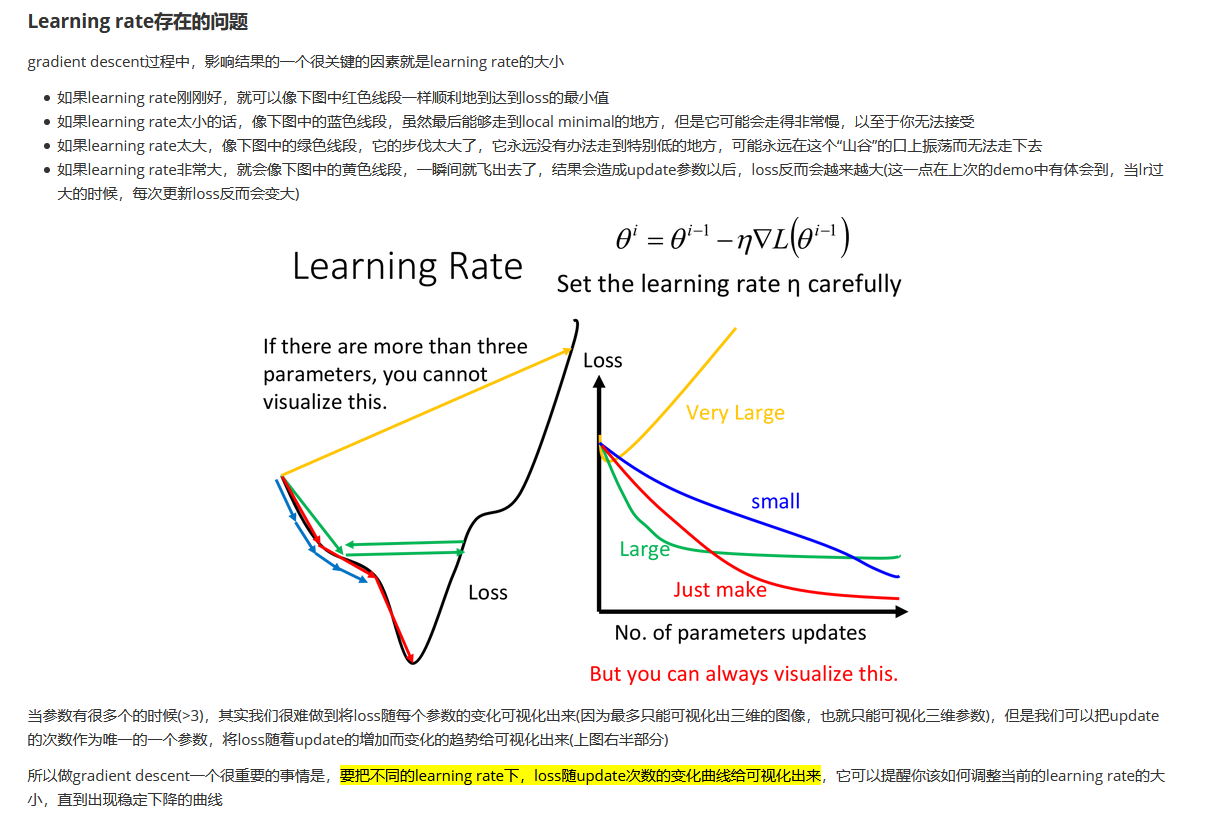